# Задание 3. Ансамбли алгоритмов. Эксперименты.
### Матвеев Артем, 317 группа

In [1]:
import sys
sys.path.append('../src')

from ensembles import RandomForestMSE, GradientBoostingMSE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
import pandas as pd

%load_ext autoreload
%autoreload 2

DEFAULT_RANDOM_STATE = 34567

1. Чтение данных и описание признаков

In [2]:
df_data = pd.read_csv('../data/kc_house_data.csv')
print(f'Data shape: {df_data.shape}')
df_data.head()

Data shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion/207885?sort=votes

* id - Unique ID for each home sold
* date - Date of the home sale
* price - Price of each home sold
* bedrooms - Number of bedrooms
* bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
* sqft_living - Square footage of the apartments interior living space
* sqft_lot - Square footage of the land space
* floors - Number of floors
* waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
* view - An index from 0 to 4 of how good the view of the property was
* condition - An index from 1 to 5 on the condition of the apartment,
* grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design and 11-13 have a high quality level of construction and design.
* sqft_above - The square footage of the interior housing space that is above ground level
* sqft_basement - The square footage of the interior housing space that is below ground level
* yr_built - The year the house was initially built
* yr_renovated - The year of the house’s last renovation
* zipcode - What zipcode area the house is in
* lat - Lattitude
* long - Longitude
* sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
* sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

2. Пропущенные и уникальные значения. Типы признаков.

In [3]:
df_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.114757e+00,7.701632e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.409430e+00,6.507430e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


* Из признака waterfront можно заметить, что всего лишь 0.7% домов располагаются на набережной, поэтому с точки зрения модели этот признак почти константный

In [4]:
print(df_data.isnull().sum(axis=0))

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


* Пропущенные значения в данных отсутствуют, что упрощает их обработку

In [5]:
print(df_data.nunique())

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64


In [6]:
print(df_data.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


* Видим, что признак id для каждого объекта уникальный и представляет из себя просто индекс дома, поэтому он не информативный и его можно выкинуть

In [7]:
df_data = df_data.drop(['id'], axis=1)

3. Распределение цены

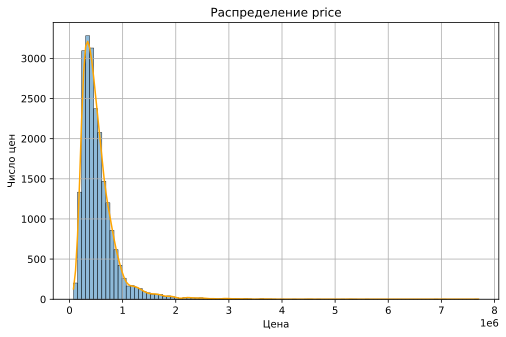

In [8]:
import seaborn as sns


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Распределение price')
ax.set_xlabel('Цена')
ax.set_ylabel('Число цен')
sns.histplot(df_data['price'], kde=True, ax=ax, bins=100)
ax.lines[0].set_color('orange')
ax.grid()
plt.show()

* Получили распределение с тяжелым правым хвостом. Распределение похоже на лог-нормальное. Проверим:

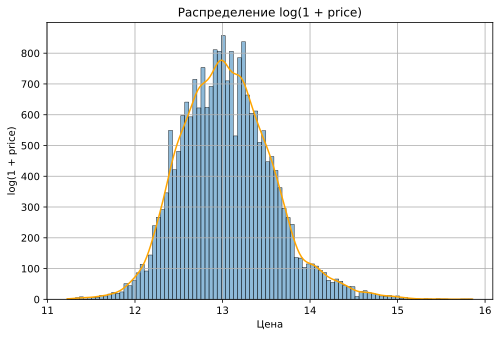

In [9]:
df_data['log_price'] = np.log1p(df_data['price'].values)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Распределение log(1 + price)')
ax.set_xlabel('Цена')
ax.set_ylabel('log(1 + price)')
sns.histplot(df_data['log_price'], kde=True, ax=ax, bins=100)
ax.lines[0].set_color('orange')
ax.grid()
plt.show()

* Распределение не очень похоже на нормальное, поэтому вариант предсказания логарифма таргета не будет рассмотрен

Преобразуем дату в pd.datetime и добавим колонки с годом покупки, месяцем покупки и днем недели покупки

In [10]:
df_data['date'] = pd.to_datetime(df_data['date'])
for time in ['year', 'month', 'dayofweek', 'day']:
    df_data[time] = getattr(df_data['date'].dt, time)
df_data = df_data.drop(['date'], axis=1)

4. Разделение на обучающую и контрольную выборки. 

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_data, test_size=0.3, shuffle=True, random_state=DEFAULT_RANDOM_STATE)
y_train = df_train['price'].values
y_val = df_val['price'].values
df_train = df_train.drop(['price', 'log_price'], axis=1)
df_val = df_val.drop(['price', 'log_price'], axis=1)
print(f'Train shape: {df_train.shape}')
print(f'Val shape: {df_val.shape}')

Train shape: (15129, 22)
Val shape: (6484, 22)


5. Числовые и категориальные признаки. Пайплайн обработки данных.

По описанию данный делаем следующие выводы:
* К категориальным признакам (признаки, на которых трудно ввести метрику или отношение порядка) точно можно отнести: **waterfront**, **zipcode** (система почтовых индексов - дорогие дома находятся рядом, поэтому у них примерно один почтовый индекс)
* К числовым признакам: **year, yr_built, yr_renovated, lat, long, bedrooms, bathrooms, sqft_living, sqft_lot, floors, view, condition, grade, sqft_above, sqft_basement, sqft_living15, sqft_lot15, dayofweek, month**
* Выше показали, что **zipcode** имеет 70 уникальных значений, что сильно бы увеличило размер признакого пространства, поэтому будет кодировать категориальные признаки с помощью mean-target кодирования

In [12]:
import category_encoders as ce


categorical = ['waterfront', 'zipcode']
cntEncoder = ce.target_encoder.TargetEncoder(cols=categorical)
X_train = cntEncoder.fit_transform(df_train, y_train).values
X_val = cntEncoder.transform(df_val, y_val).values
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (15129, 22)
X_val shape: (6484, 22)


/home/matfu21/.local/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/matfu21/.local/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


### Линейная регрессия 

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)
print(mean_squared_error(y_val, model.predict(X_val), squared=False))

165896.0541352344


### Случайный лес

In [13]:
BASE_N_ESTIMATORS = 1000

In [14]:
randomForest = RandomForestMSE(n_estimators=BASE_N_ESTIMATORS, random_state=DEFAULT_RANDOM_STATE)
historyRF = randomForest.fit(X_train, y_train, X_val, y_val, trace=True)

(21, 139041.4419756572)


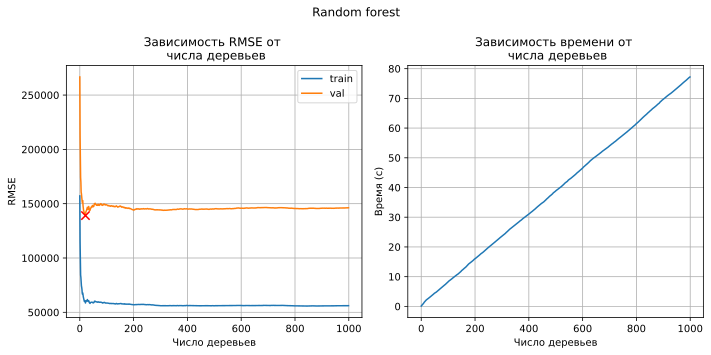

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(historyRF['score_train'], label='train')
ax1.plot(historyRF['score_val'], label='val')
ax1.scatter(x=historyRF['best_pair'][0], y=historyRF['best_pair'][1], marker='x', color='red', s=70, zorder=3)
ax1.grid()
ax1.legend()
ax1.set_xlabel('Число деревьев')
ax1.set_title('Зависимость RMSE от \n числа деревьев')
ax1.set_ylabel('RMSE')

ax2.plot(historyRF['time'])
ax2.grid()
ax2.set_xlabel('Число деревьев')
ax2.set_title('Зависимость времени от \n числа деревьев')
ax2.set_ylabel('Время (с)')

fig.suptitle('Random forest')
fig.tight_layout()
fig.show()
fig.savefig('1.pdf')
print(historyRF['best_pair'])

* После 22 деревьев (нумерация с нуля) наблюдается переобучение.

In [16]:
from tqdm import tqdm


number_of_features = [9, 14, 19, X_train.shape[1]]
histories = dict()
histories['rf'] = dict()
histories['rf']['n_features'] = dict()

for n_features in tqdm(number_of_features):
    randomForest = RandomForestMSE(n_estimators=BASE_N_ESTIMATORS, feature_subsample_size=n_features, random_state=DEFAULT_RANDOM_STATE)
    histories['rf']['n_features'][n_features] = randomForest.fit(X_train, y_train, X_val, y_val, trace=True)

100%|██████████| 4/4 [16:02<00:00, 240.64s/it]


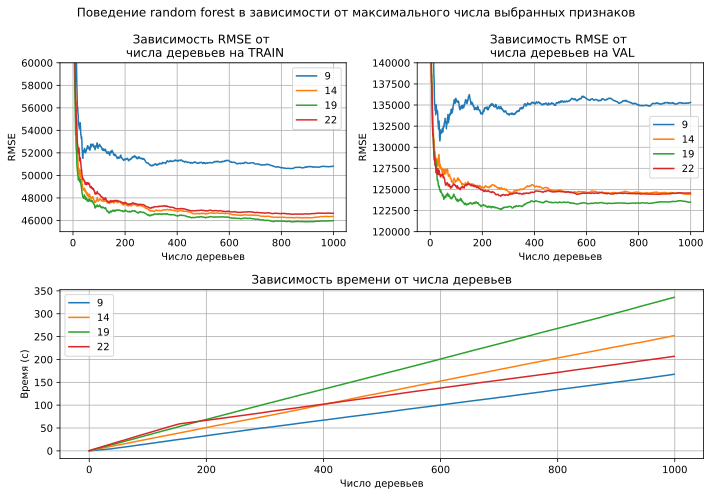

In [17]:
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3,4))

for n_features in number_of_features:
    ax1.plot(histories['rf']['n_features'][n_features]['score_train'], label=str(n_features))
    ax2.plot(histories['rf']['n_features'][n_features]['score_val'], label=str(n_features))
    ax3.plot(histories['rf']['n_features'][n_features]['time'], label=str(n_features))

ax1.set_title('Зависимость RMSE от \n числа деревьев на TRAIN')
ax1.set_xlabel('Число деревьев')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.set_ylim((45000, 60000))
ax1.legend()

ax2.set_title('Зависимость RMSE от \n числа деревьев на VAL')
ax2.set_xlabel('Число деревьев')
ax2.set_ylabel('RMSE')
ax2.grid()
ax2.set_ylim((120000, 140000))
ax2.legend()

ax3.set_title('Зависимость времени от числа деревьев')
ax3.set_xlabel('Число деревьев')
ax3.set_ylabel('Время (с)')
ax3.grid()
ax3.legend()

fig.suptitle('Поведение random forest в зависимости от максимального числа выбранных признаков')
fig.tight_layout()
fig.savefig('2.pdf')
fig.show()

* Лучшим параметром на валидации оказалось feature_subsample_size=19. Для дальнейших экспериментов зафиксируем этот параметр. 

In [18]:
max_depths = [10, 15, 20, None]
BASE_N_FEATURES = 19

histories['rf']['max_depth'] = dict()

for max_depth in tqdm(max_depths):
    randomForest = RandomForestMSE(n_estimators=BASE_N_ESTIMATORS, feature_subsample_size=BASE_N_FEATURES, max_depth=max_depth, random_state=DEFAULT_RANDOM_STATE)
    histories['rf']['max_depth'][max_depth] = randomForest.fit(X_train, y_train, X_val, y_val, trace=True)

100%|██████████| 4/4 [08:25<00:00, 126.42s/it]


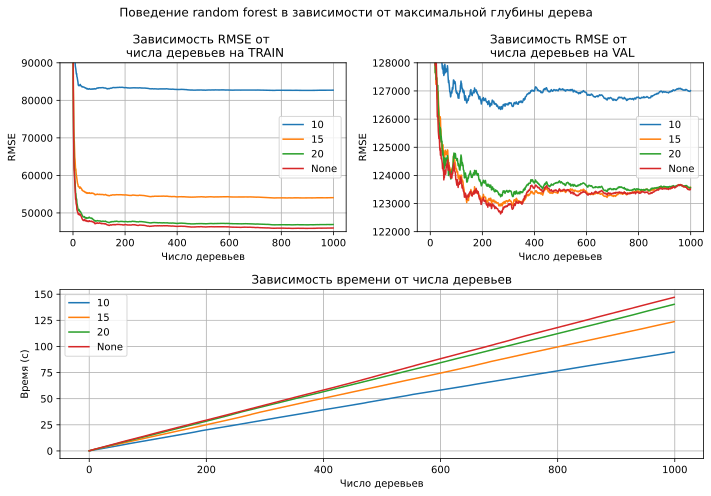

In [19]:
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3,4))

for max_depth in max_depths:
    ax1.plot(histories['rf']['max_depth'][max_depth]['score_train'], label=str(max_depth))
    ax2.plot(histories['rf']['max_depth'][max_depth]['score_val'], label=str(max_depth))
    ax3.plot(histories['rf']['max_depth'][max_depth]['time'], label=str(max_depth))

ax1.set_title('Зависимость RMSE от \n числа деревьев на TRAIN')
ax1.set_xlabel('Число деревьев')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.set_ylim((45000, 90000))
ax1.legend()

ax2.set_title('Зависимость RMSE от \n числа деревьев на VAL')
ax2.set_xlabel('Число деревьев')
ax2.set_ylabel('RMSE')
ax2.grid()
ax2.set_ylim((122000, 128000))
ax2.legend()

ax3.set_title('Зависимость времени от числа деревьев')
ax3.set_xlabel('Число деревьев')
ax3.set_ylabel('Время (с)')
ax3.grid()
ax3.legend()

fig.suptitle('Поведение random forest в зависимости от максимальной глубины дерева')
fig.tight_layout()
fig.savefig('3.pdf')
fig.show()

In [29]:
print(min(histories['rf']['max_depth'][max_depth]['score_val']))

122630.5653382991


* Здесь ожидаемого лучше всего себя показывают наиболее глубокие деревья (параметр None)

### Градиентный бустинг

In [20]:
gradientBoosting = GradientBoostingMSE(n_estimators=BASE_N_ESTIMATORS, random_state=DEFAULT_RANDOM_STATE)
historyGB = gradientBoosting.fit(X_train, y_train, X_val, y_val, trace=True)

(940, 117627.91647967826)


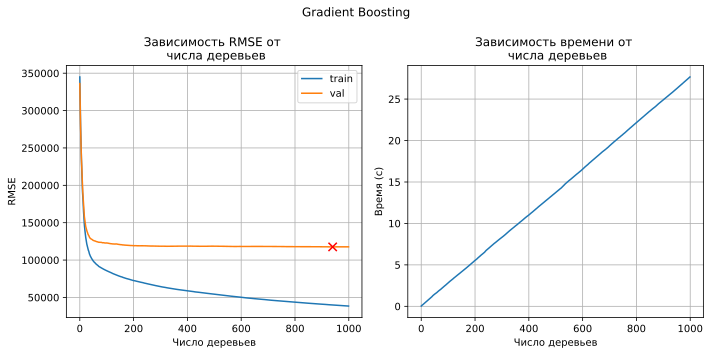

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(historyGB['score_train'], label='train')
ax1.plot(historyGB['score_val'], label='val')
ax1.scatter(x=historyGB['best_pair'][0], y=historyGB['best_pair'][1], marker='x', color='red', s=70, zorder=3)
ax1.grid()
ax1.legend()
ax1.set_xlabel('Число деревьев')
ax1.set_title('Зависимость RMSE от \n числа деревьев')
ax1.set_ylabel('RMSE')

ax2.plot(historyGB['time'])
ax2.grid()
ax2.set_xlabel('Число деревьев')
ax2.set_title('Зависимость времени от \n числа деревьев')
ax2.set_ylabel('Время (с)')

fig.suptitle('Gradient Boosting')
fig.tight_layout()
fig.show()
fig.savefig('4.pdf')
print(historyGB['best_pair'])

* Лучшее значение n_estimators=940

In [22]:
number_of_features = [9, 14, 19, X_train.shape[1]]
histories['gb'] = dict()
histories['gb']['n_features'] = dict()

for n_features in tqdm(number_of_features):
    gradientBoosting = GradientBoostingMSE(n_estimators=BASE_N_ESTIMATORS, feature_subsample_size=n_features, random_state=DEFAULT_RANDOM_STATE)
    histories['gb']['n_features'][n_features] = gradientBoosting.fit(X_train, y_train, X_val, y_val, trace=True)

100%|██████████| 4/4 [03:23<00:00, 50.88s/it]


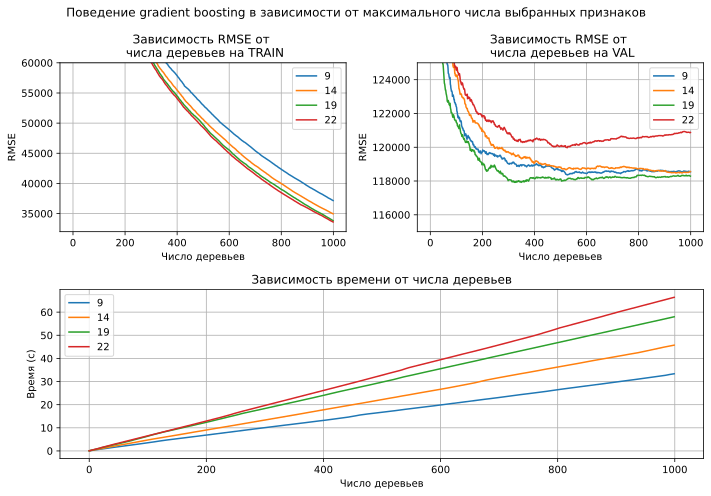

In [23]:
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3,4))

for n_features in number_of_features:
    ax1.plot(histories['gb']['n_features'][n_features]['score_train'], label=str(n_features))
    ax2.plot(histories['gb']['n_features'][n_features]['score_val'], label=str(n_features))
    ax3.plot(histories['gb']['n_features'][n_features]['time'], label=str(n_features))

ax1.set_title('Зависимость RMSE от \n числа деревьев на TRAIN')
ax1.set_xlabel('Число деревьев')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.set_ylim((32000, 60000))
ax1.legend()

ax2.set_title('Зависимость RMSE от \n числа деревьев на VAL')
ax2.set_xlabel('Число деревьев')
ax2.set_ylabel('RMSE')
ax2.grid()
ax2.set_ylim((115000, 125000))
ax2.legend()

ax3.set_title('Зависимость времени от числа деревьев')
ax3.set_xlabel('Число деревьев')
ax3.set_ylabel('Время (с)')
ax3.grid()
ax3.legend()

fig.suptitle('Поведение gradient boosting в зависимости от максимального числа выбранных признаков')
fig.tight_layout()
fig.savefig('5.pdf')
fig.show()

* Лучшим параметром максимального числа выбранных признаков является 19

In [24]:
max_depths = [3, 5, 7, 9, None]
BASE_N_FEATURES = 19

histories['gb']['max_depth'] = dict()

for max_depth in tqdm(max_depths):
    gradientBoosting = GradientBoostingMSE(n_estimators=BASE_N_ESTIMATORS, feature_subsample_size=BASE_N_FEATURES, max_depth=max_depth, random_state=DEFAULT_RANDOM_STATE)
    histories['gb']['max_depth'][max_depth] = gradientBoosting.fit(X_train, y_train, X_val, y_val, trace=True)

100%|██████████| 5/5 [09:32<00:00, 114.48s/it]


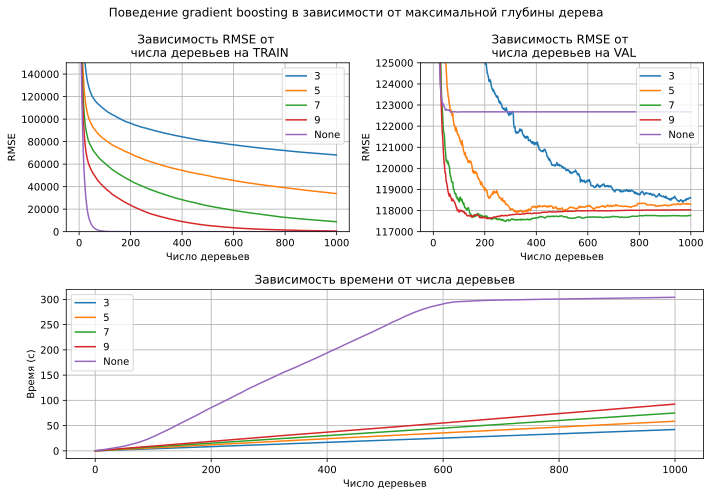

In [25]:
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3,4))

for max_depth in max_depths:
    ax1.plot(histories['gb']['max_depth'][max_depth]['score_train'], label=str(max_depth))
    ax2.plot(histories['gb']['max_depth'][max_depth]['score_val'], label=str(max_depth))
    ax3.plot(histories['gb']['max_depth'][max_depth]['time'], label=str(max_depth))

ax1.set_title('Зависимость RMSE от \n числа деревьев на TRAIN')
ax1.set_xlabel('Число деревьев')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.set_ylim((0, 150000))
ax1.legend()

ax2.set_title('Зависимость RMSE от \n числа деревьев на VAL')
ax2.set_xlabel('Число деревьев')
ax2.set_ylabel('RMSE')
ax2.grid()
ax2.set_ylim((117000, 125000))
ax2.legend()

ax3.set_title('Зависимость времени от числа деревьев')
ax3.set_xlabel('Число деревьев')
ax3.set_ylabel('Время (с)')
ax3.grid()
ax3.legend()

fig.suptitle('Поведение gradient boosting в зависимости от максимальной глубины дерева')
fig.tight_layout()
fig.savefig('6.pdf')
fig.show()

* Лучшим параметром на валидации является max_dept=7. Зафиксируем его для следующего эксперимента

In [26]:
learn_rates = [0.001, 0.01, 0.1, 1]
BASE_MAX_DEPTH = 7

histories['gb']['learn_rate'] = dict()

for lr in tqdm(learn_rates):
    gradientBoosting = GradientBoostingMSE(n_estimators=BASE_N_ESTIMATORS, feature_subsample_size=BASE_N_FEATURES, max_depth=BASE_MAX_DEPTH, learning_rate=lr, random_state=DEFAULT_RANDOM_STATE)
    histories['gb']['learn_rate'][lr] = gradientBoosting.fit(X_train, y_train, X_val, y_val, trace=True)

100%|██████████| 4/4 [04:47<00:00, 71.85s/it]


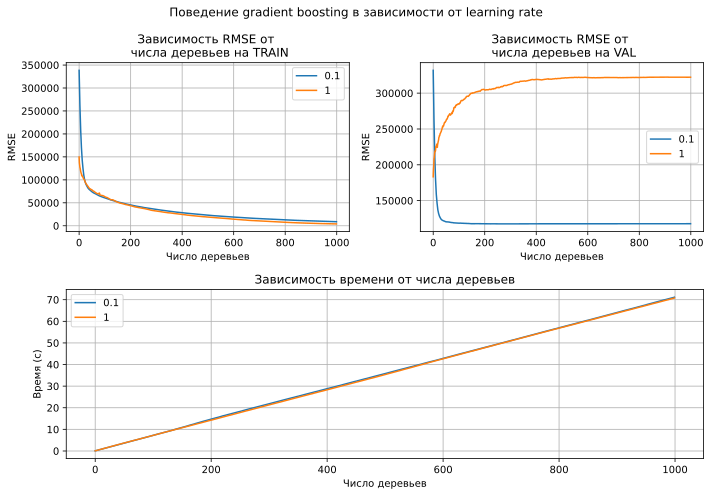

In [27]:
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3,4))

for lr in learn_rates[2:]:
    ax1.plot(histories['gb']['learn_rate'][lr]['score_train'], label=str(lr))
    ax2.plot(histories['gb']['learn_rate'][lr]['score_val'], label=str(lr))
    ax3.plot(histories['gb']['learn_rate'][lr]['time'], label=str(lr))

ax1.set_title('Зависимость RMSE от \n числа деревьев на TRAIN')
ax1.set_xlabel('Число деревьев')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.legend()

ax2.set_title('Зависимость RMSE от \n числа деревьев на VAL')
ax2.set_xlabel('Число деревьев')
ax2.set_ylabel('RMSE')
ax2.grid()
ax2.legend()

ax3.set_title('Зависимость времени от числа деревьев')
ax3.set_xlabel('Число деревьев')
ax3.set_ylabel('Время (с)')
ax3.grid()
ax3.legend()

fig.suptitle('Поведение gradient boosting в зависимости от learning rate')
fig.tight_layout()
fig.savefig('7.pdf')
fig.show()

In [31]:
histories['gb']['learn_rate'][0.01]['score_val'][-1]

115386.91845539401

* Здесь лучшим шагом является шаг 0.01